## Playground with some EDA and misc uses

##### Column info

collaborative returns t/f
description returns text
take nothing from external_urls
followers['total'] is the int
nothing from href
id is the id
nothing from image
text from name
can get username from my query not from owner
['tracks']['total'] gives you number of tracks

tracks data frame
from tracks items ['added_at'] get the data time the track was added
from tracks items ['track'] get duration_ms as float
for artist in tracks items ['track']['artists'][0]['name'] get the first artist
from tracks items ['track'] get explicit as bool
from tracks items ['track'] get id as string
from tracks items ['track'] get name as string
from tracks items ['track'] get popularity as float (0-100)

In [116]:
# imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from gensim.models.word2vec import Word2Vec, KeyedVectors
import html
import re
import itertools
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist

sns.set_context('paper')
sns.set_style('white')
sns.color_palette('muted')
%matplotlib inline

In [2]:
# Get the data
current_df = utils.make_working_df()
current_df.head()

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,artist_followers,artist_genre,...,pl_min_trkpop,pl_max_trkpop,pl_mean_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,76.0,None,...,0.0,4.0,1.333333,0.0,6.0,1.764706,13,crap_factory,515,0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,76.0,None,...,0.0,4.0,1.333333,0.0,6.0,1.764706,13,crap_factory,515,0
2,2014-07-16 13:50:24,J Boog,217270.0,0.0,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0,103793.0,[polynesian pop],...,0.0,72.0,38.269231,0.0,58.0,38.419355,20,star,166,0
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,122496.0,[hardstyle],...,0.0,58.0,15.510000,0.0,47.0,11.272727,18,crap_factory,166,0
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,1281.0,None,...,0.0,0.0,0.000000,0.0,0.0,0.000000,1,garage_band,1731,0


In [3]:
len(current_df['pl_owner'].drop_duplicates())

846

In [4]:
len(current_df['pl_id'].drop_duplicates())

8183

In [31]:
current_df.columns

Index(['trk_added_at', 'art_name', 'trk_duration', 'explicit', 'trk_id',
       'trk_name', 'pl_id', 'trk_popularity', 'artist_followers',
       'artist_genre', 'artist_id', 'artist_pop', 'collab', 'pl_desc',
       'pl_followers', 'pl_name', 'pl_num_trks', 'pl_owner', 'user_followers',
       'pl_first_date', 'pl_last_date', 'pl_days_active', 'pl_days_old',
       'pl_num_trk', 'pl_num_art', 'pl_min_trkpop', 'pl_max_trkpop',
       'pl_mean_trkpop', 'art_min_trkpop', 'art_max_trkpop', 'art_mean_trkpop',
       'art_total_trks', 'art_class', 'user_pls_in_sample', 'pl_desc_chars'],
      dtype='object')

In [3]:
pl_names = current_df[['pl_id','pl_name']].drop_duplicates()
print(len(pl_names))
pl_names.head()


8183


,pl_id,pl_name
0,3ftsSOkyCsILZeAZYQr2jH,Allgott o villgott
2,35XFuuqgCvTYQARix7CFpm,reggae
3,0gGfciue2ZDCOG5uMv46gU,Ηardstyle♬ WORLD OF HARDSTYLE | Wildstylez | N...
4,6Tuex6CIDfZRyRtsmb5rwE,50's Jukebox Hits
5,5xL1c6RCMhVDTVLZUsY5SR,Tina Mehrafzoon - Favoriter


In [64]:
def clean_text(txt,flag='list'):
    txt = txt.lower()
    txt = html.unescape(txt)
    txt = ''.join(''.join(s)[:2] for _, s in itertools.groupby(txt))
    txt = re.sub('[^A-Za-z\s]+','',txt)
    txt = word_tokenize(txt)
    sw = set(stopwords.words('english'))
    ssw = set(stopwords.words('spanish'))
    out = []
    for word in txt:
        
        if word not in sw and word not in ssw:
            out.append(word)
            
    out = [w for w in out if w.strip()!='']
    if flag=='list':
        return out
    elif flag=='text':
        return ' '.join(out)


In [65]:
pl_names['clean_name'] = [clean_text(p) for p in pl_names['pl_name']]
print(len(pl_names))
pl_names.head()

8183


,pl_id,pl_name,clean_name
0,3ftsSOkyCsILZeAZYQr2jH,allgott villgott,"[allgott, villgott]"
2,35XFuuqgCvTYQARix7CFpm,reggae,[reggae]
3,0gGfciue2ZDCOG5uMv46gU,ardstyle world hardstyle wildstylez noisecontr...,"[ardstyle, world, hardstyle, wildstylez, noise..."
4,6Tuex6CIDfZRyRtsmb5rwE,jukebox hits,"[jukebox, hits]"
5,5xL1c6RCMhVDTVLZUsY5SR,tina mehrafzoon favoriter,"[tina, mehrafzoon, favoriter]"


In [57]:
nwv = word2vec.KeyedVectors.load('w2v/word2vec_model')

In [66]:
word_vectors = []
for w in pl_names['clean_name']:
    agg_vec = np.zeros(100)
    for n in w:
        try:
            agg_vec += nwv.word_vec(n) 
        except:
            pass
    word_vectors.append(agg_vec)

print('total playlists with names',len(word_vectors))
plists_w_vec_rep = len([w for w in word_vectors if not np.array_equal(w,np.zeros(100))])
print('total playlists as non-zero vectors',plists_w_vec_rep)
print('percentage of playlists with vector representation',plists_w_vec_rep/len(word_vectors))

total playlists with names 8183
total playlists as non-zero vectors 6835
percentage of playlists with vector representation 0.8352682390321398


In [68]:
pl_names['w2v'] = word_vectors
pl_names = pl_names.drop('clean_name',axis=1)
print(len(pl_names))
pl_names.head()

8183


,pl_id,pl_name,w2v
0,3ftsSOkyCsILZeAZYQr2jH,allgott villgott,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,35XFuuqgCvTYQARix7CFpm,reggae,"[-0.108421981335, 0.220556214452, 0.4266166985..."
3,0gGfciue2ZDCOG5uMv46gU,ardstyle world hardstyle wildstylez noisecontr...,"[2.51007777452, -2.81740119774, 0.297188825905..."
4,6Tuex6CIDfZRyRtsmb5rwE,jukebox hits,"[-1.95629256591, -0.241700597107, -0.581438588..."
5,5xL1c6RCMhVDTVLZUsY5SR,tina mehrafzoon favoriter,"[0.00500876270235, -0.0775637342595, -0.266624..."


In [79]:
X = np.array([i for i in pl_names['w2v']])
print(X.shape)

(8183, 100)


In [80]:
# Viz
tsne5 = TSNE(perplexity=5).fit_transform(X)
tsne10 = TSNE(perplexity=10).fit_transform(X)
tsne15 = TSNE(perplexity=15).fit_transform(X)
tsne20 = TSNE(perplexity=20).fit_transform(X)
tsne30 = TSNE(perplexity=30).fit_transform(X)
tsne40 = TSNE(perplexity=40).fit_transform(X)
tsne50 = TSNE(perplexity=50).fit_transform(X)

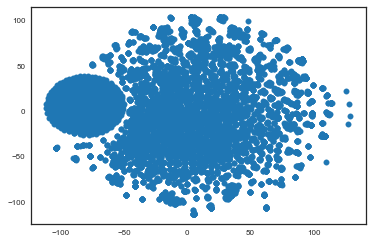

In [81]:
# perp=5
plt.scatter(tsne5[:,0],tsne5[:,1])
# plt.savefig('perp5')

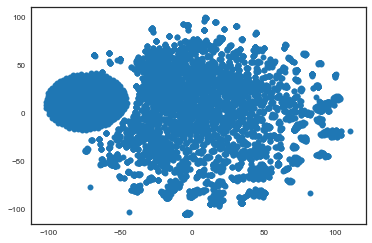

In [82]:
# perp=10
plt.scatter(tsne10[:,0],tsne10[:,1])
# plt.savefig('perp10')

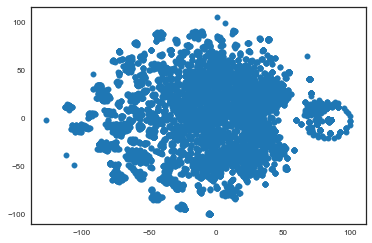

In [83]:
# perp=15
plt.scatter(tsne15[:,0],tsne15[:,1])
# plt.savefig('perp15')

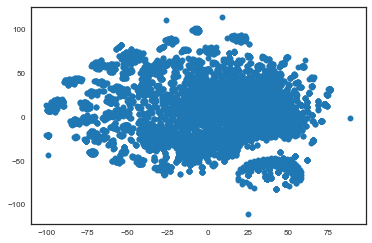

In [84]:
# perp=20
plt.scatter(tsne20[:,0],tsne20[:,1])
# plt.savefig('perp20')

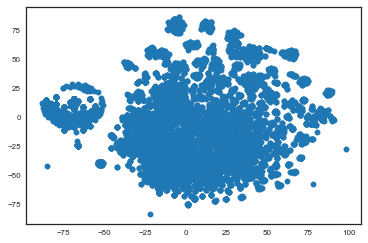

In [78]:
plt.scatter(tsne30[:,0],tsne30[:,1],cmap=plt.cm.viridis)
# plt.savefig('perp30')

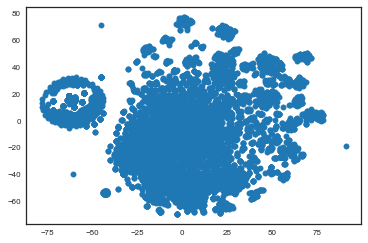

In [85]:
# perp=40
plt.scatter(tsne40[:,0],tsne40[:,1])
# plt.savefig('perp40')

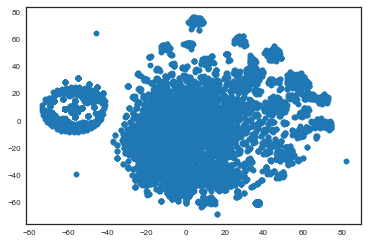

In [86]:
# perp=50
plt.scatter(tsne50[:,0],tsne50[:,1])
# plt.savefig('perp50')

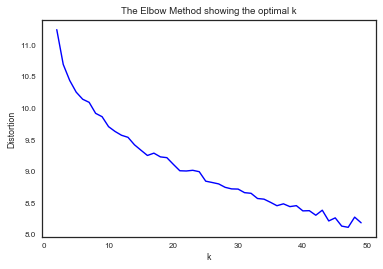

In [118]:
# k means determine k
distortions = []
K = list(range(2,50))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [119]:
# K means clustering
# Based on the elbow plot above I choose 16 as the k for k-means
clusters = KMeans(n_clusters=16,random_state=9921).fit(X)
clusters.labels_.shape

(8183,)

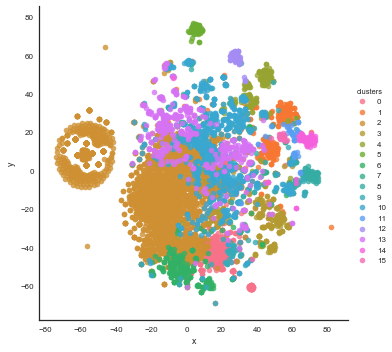

In [124]:
plot_df = pd.DataFrame({'x':tsne50[:,0],'y':tsne50[:,1],'clusters': clusters.labels_})
sns.lmplot(x='x',y='y',hue='clusters', data=plot_df,fit_reg=False)
# plt.savefig('w2v_clusters16_tsne50')

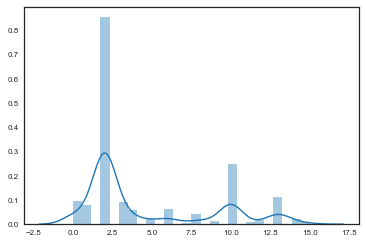

In [121]:
# Distribution of the cluster labels.
sns.distplot(clusters.labels_)

In [90]:
pl_names['cluster'] = clusters.labels_
pl_names = pl_names.drop(['w2v','pl_name'],axis=1)
pl_names.head()

,pl_id,pl_name,cluster
0,3ftsSOkyCsILZeAZYQr2jH,allgott villgott,6
2,35XFuuqgCvTYQARix7CFpm,reggae,6
3,0gGfciue2ZDCOG5uMv46gU,ardstyle world hardstyle wildstylez noisecontr...,7
4,6Tuex6CIDfZRyRtsmb5rwE,jukebox hits,4
5,5xL1c6RCMhVDTVLZUsY5SR,tina mehrafzoon favoriter,6


In [123]:
pl_names.head()

,pl_id,cluster
0,3ftsSOkyCsILZeAZYQr2jH,2
2,35XFuuqgCvTYQARix7CFpm,2
3,0gGfciue2ZDCOG5uMv46gU,8
4,6Tuex6CIDfZRyRtsmb5rwE,10
5,5xL1c6RCMhVDTVLZUsY5SR,2


In [3]:
# current_df[['track_name','artist','track_pop']].drop_duplicates().sort_values('track_pop',ascending=False)

In [4]:
# for row in current_df['']
# print(current_df.columns)
ad = current_df[['artist_id','artist','artist_followers','artist_pop','artist_genre']].drop_duplicates('artist_id'
                                                            ).sort_values('artist_pop',ascending=False)
ad.head()

,artist_id,artist,artist_followers,artist_pop,artist_genre
70,246dkjvS1zLTtiykXe5h60,Post Malone,1983963.0,100.0,"[pop rap, rap]"
9387,6LuN9FCkKOj5PcnpouEgny,Khalid,1106550.0,99.0,None
620,3TVXtAsR1Inumwj472S9r4,Drake,14093269.0,99.0,"[canadian pop, hip hop, pop rap, rap]"
1688,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,14150392.0,99.0,[pop]
360,1URnnhqYAYcrqrcwql10ft,21 Savage,2244008.0,98.0,"[dwn trap, rap, trap music]"


In [5]:
current_df['artist_genre'] = [g if type(g)==list else [] for g in current_df['artist_genre']]
bigdf = utils.explode_value(current_df,'artist_genre')

In [16]:
best_g = bigdf[['artist_genre','artist_pop']].groupby('artist_genre',as_index=False).mean().sort_values('artist_pop',ascending=False)

In [38]:
import matplotlib
font = {'size'   : 38,
       'weight':'normal'}

matplotlib.rc('font', **font)

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


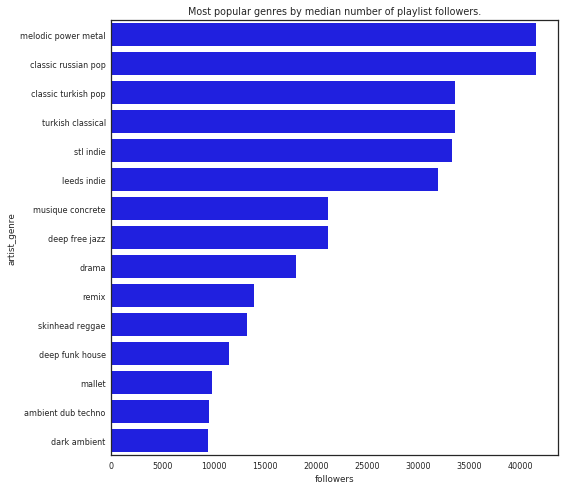

In [61]:
temp = bigdf[bigdf['track_pop']>100]
best_f = bigdf[['artist_genre','followers']].groupby('artist_genre',as_index=False).median().sort_values('followers',ascending=False)
print()
best_f = best_f.head(15)
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=best_f,y='artist_genre',x='followers',color='blue',ax=ax)
plt.title('Most popular genres by median number of playlist followers.')
plt.savefig('genre_followers')

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


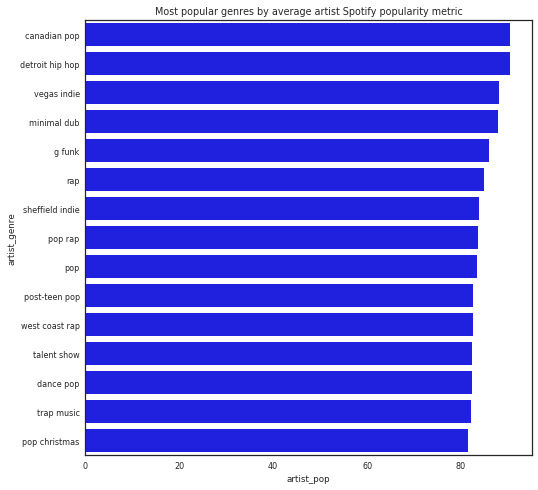

In [39]:
# sns.barplot(data=adf,y='artist_genre',x='artist_pop')
best_g = best_g.head(15)
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=best_g,y='artist_genre',x='artist_pop',color='blue',ax=ax)
plt.title('Most popular genres by average artist Spotify popularity metric')
plt.savefig('genre_pop')

In [15]:
adf = bigdf[bigdf['artist_genre'].isin(best_g)]
print(len(adf))
adf.head()

480040


,added_at,artist,artist_followers,artist_genre,artist_id,artist_pop,collab,desc,duration,explicit,followers,num_tracks,playlist_id,playlist_name,track_id,track_name,track_pop,user,user_followers
7,2014-08-04 16:09:48,Becky G,1450915.0,dance pop,4obzFoKoKRHIphyHzJ35G3,85.0,False,None,206166.0,0.0,43.0,26,5BASWniNjjZADnD9i96L45,LIL'BITCH,3DmW6y7wTEYHJZlLo1r6XJ,Shower,70.0,thomasaunier,3812.0
8,2014-08-04 16:09:48,Becky G,1450915.0,pop,4obzFoKoKRHIphyHzJ35G3,85.0,False,None,206166.0,0.0,43.0,26,5BASWniNjjZADnD9i96L45,LIL'BITCH,3DmW6y7wTEYHJZlLo1r6XJ,Shower,70.0,thomasaunier,3812.0
9,2014-08-04 16:09:48,Becky G,1450915.0,post-teen pop,4obzFoKoKRHIphyHzJ35G3,85.0,False,None,206166.0,0.0,43.0,26,5BASWniNjjZADnD9i96L45,LIL'BITCH,3DmW6y7wTEYHJZlLo1r6XJ,Shower,70.0,thomasaunier,3812.0
13,2013-08-03 17:10:52,Elton John,1191231.0,glam rock,3PhoLpVuITZKcymswpck5b,82.0,False,None,290680.0,0.0,0.0,31,6uSxJmUwlS3RqjGEA0TRq8,Elton John,1DqMnZpdOXy4mjmsXnFv2t,Circle Of Life,4.0,ellenholstad,254.0
31,2017-08-20 10:53:49,Tony! Toni! Toné!,197033.0,dance pop,7vWlb4pM85jCHvV771qZZW,61.0,False,All the hits that all Batang &#x27;90s loved l...,241466.0,0.0,7.0,127,0mEm0SZ7WsnI3w8ycnO6ue,The Fantastic '90s,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,37.0,1177637361,NaN


/Users/paulblankley/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


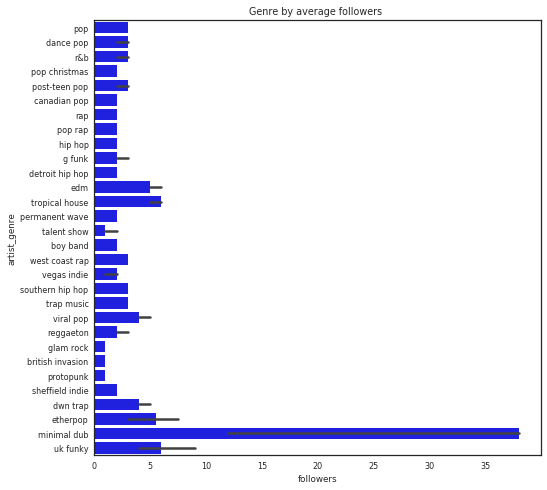

In [45]:
adf = adf.sort_values('artist_followers',ascending=False)
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=adf,y='artist_genre',x='followers',color='blue',estimator=np.median,ax=ax)
plt.title('Genre by average followers ')

## Possible outside Spotify datasources.

The sqlite database below is from the million song dataset people, and the txt file is also from them, but for a different project.

In [22]:
# table of interest is songs

# Columns 
# 0|track_id|text|0||1
# 1|title|text|0||0
# 2|song_id|text|0||0
# 3|release|text|0||0
# 4|artist_id|text|0||0
# 5|artist_mbid|text|0||0
# 6|artist_name|text|0||0
# 7|duration|real|0||0
# 8|artist_familiarity|real|0||0
# 9|artist_hotttnesss|real|0||0
# 10|year|int|0||0
# 11|track_7digitalid|int|0||0
# 12|shs_perf|int|0||0
# 13|shs_work|int|0||0

dpath = '/Users/paulblankley/Desktop/track_metadata.db'
import sqlite3 
db = sqlite3.connect(dpath)
cursor = db.cursor()
data_sql = cursor.execute("select title, artist_name from songs").fetchall()

df_dict = {'trk_name': [], 'art_name': []}
for i in data_sql:
    df_dict['trk_name'].append(i[0])
    df_dict['art_name'].append(i[1])

In [23]:
sqlite_df = pd.DataFrame(df_dict)

In [24]:
length = len(pd.merge(current_df,sqlite_df,how='inner',on=['trk_name','art_name']))
print('there are {0} shared rows between the MSdb and our pulled data.'.format(length))

there are 84402 shared rows between the MSdb and our pulled data.


In [11]:
cursor.execute("select * from songs limit 5").fetchall()

[('TRMMMYQ128F932D901',
  'Silent Night',
  'SOQMMHC12AB0180CB8',
  'Monster Ballads X-Mas',
  'ARYZTJS1187B98C555',
  '357ff05d-848a-44cf-b608-cb34b5701ae5',
  'Faster Pussy cat',
  252.05506,
  0.649822100201,
  0.394031892714,
  2003,
  7032331,
  -1,
  0),
 ('TRMMMKD128F425225D',
  'Tanssi vaan',
  'SOVFVAK12A8C1350D9',
  'Karkuteillä',
  'ARMVN3U1187FB3A1EB',
  '8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9',
  'Karkkiautomaatti',
  156.55138,
  0.439603966677,
  0.356992107756,
  1995,
  1514808,
  -1,
  0),
 ('TRMMMRX128F93187D9',
  'No One Could Ever',
  'SOGTUKN12AB017F4F1',
  'Butter',
  'ARGEKB01187FB50750',
  '3d403d44-36ce-465c-ad43-ae877e65adc4',
  'Hudson Mohawke',
  138.97098,
  0.643680572058,
  0.437503836595,
  2006,
  6945353,
  -1,
  0),
 ('TRMMMCH128F425532C',
  'Si Vos Querés',
  'SOBNYVR12A8C13558C',
  'De Culo',
  'ARNWYLR1187B9B2F9C',
  '12be7648-7094-495f-90e6-df4189d68615',
  'Yerba Brava',
  145.05751,
  0.448501159656,
  0.372349068517,
  2003,
  2168257,
  -1,
  0

In [28]:
with open('data/msd_genre_dataset.txt', 'r') as file:
    txt = file.read().split('\n')[9:-1]
    
meta = [line.split(',') for line in txt]
mdf = pd.DataFrame(meta[1:],columns=meta[0])   
mdf = mdf.rename(columns={'artist_name': 'art_name', 'title': 'trk_name'})

In [29]:
mdf.head()

,%genre,track_id,art_name,trk_name,loudness,tempo,time_signature,key,mode,duration,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,...,1255.51456863,580.030471741,598.485222763,575.337671354,322.068602573,321.726029279,232.700608628,186.805302819,181.938688381,151.50801133
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,...,2007.65306963,1043.47407325,585.694981147,564.013735701,510.17702214,400.200186221,365.119588173,238.099707901,197.93375698,251.577525425
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.1971,...,1204.85677694,2736.52002367,730.233238915,665.203451745,535.775110987,439.335059128,486.822970218,265.333860063,447.097986712,251.880723932
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,...,809.755802415,563.908070151,492.803818867,378.382799225,372.875044164,231.941956807,246.313305313,168.400152003,85.2824617673,339.897173243
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,...,1093.68493472,343.556047412,889.163313941,218.111795637,304.862864449,178.352161145,440.478866943,142.669282985,81.0613261338,208.355152377


In [30]:
print('there are ',len(pd.merge(mdf,current_df,how='inner',on=['trk_name','art_name'])),'matching rows for tracks in this data.')

there are  7063 matching rows for tracks in this data.
